## Data


Here we need to  predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.


The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

#### Transaction data 

* Transactionid: Id related to transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD  [Categorical]: product code(the product for each transaction)
* card1 - 6 [Categorical]: payment card related information like card type, country etc
* addr1, addr2 [Categorical]: address information
* dist1,dist2: some distance information
* P_emaildomain [Categorical]: email domain of purchaser
* R_emaildomain [Categorical]: emaildomain of recipient
* C1-C14:  counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9 [Categorical]: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.



#### Identity data

* Transactionid: Id related to transaction
* DeviceType [Categorical]: Type of device used for transaction
* DeviceInfo [Categorical]: More information about device used
* id 1 - 38 [Categorical+numeric]: network connection information,browser information etc (id 12 - 38 are categorical information)

Note: Actually we dont have access to exact information about columns. Mostly it is beacuse of security purposes as we are handling transaction data.




## EDA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb
# import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [6]:
train_data = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')

In [7]:
dt = [train_data, train_identity]
data = pd.concat(dt, ignore_index = True)

In [8]:
train_data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [9]:
train_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [10]:
train_data.tail(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
590520,3577520,0,15810785,93.000,W,17150,292.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590521,3577521,0,15810802,48.877,C,12019,305.0,106.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590522,3577522,0,15810823,54.500,W,3166,559.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590523,3577523,0,15810833,58.950,W,13076,456.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590524,3577524,0,15810836,75.000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590525,3577525,0,15810866,57.950,W,11942,570.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590526,3577526,1,15810876,250.000,R,1214,174.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590527,3577527,0,15810883,189.950,W,6453,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590528,3577528,0,15810907,279.950,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590529,3577529,0,15810912,73.838,C,5096,555.0,185.0,mastercard,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# #combining frames

# df_train_transaction = pd.read_csv('data/train_transaction.csv')
# df_train_identity = pd.read_csv('data/train_identity.csv')
# df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')


# df_test_transaction = pd.read_csv('data/test_transaction.csv')
# df_test_identity = pd.read_csv('data/test_identity.csv')

# # some columns (id) are wrongly labeled in test_identity. We will correct it
# id_cols = [col for col in df_test_identity.columns if col[0]+col[1] == 'id']
# rename_cols = {i:'id_'+str(i[-2]+i[-1]) for i in id_cols}
# df_test_identity = df_test_identity.rename(columns=rename_cols)
# df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')


# df_train.to_csv('data/train_combined.csv',index=False)
# df_test.to_csv('data/test_combined.csv',index=False)

In [12]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(506691, 433)


### Checking Missing values

In [13]:
def top_missing_cols(df,n=10,thresh=80):

    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [14]:
top_missing_cols(df_train,thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [15]:
top_missing_cols(df_test,thresh=90)

There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.064519
1,id_25,99.005508
2,id_26,99.003929
3,id_21,99.001561
4,id_08,99.001561
5,id_07,99.001561
6,id_27,99.000969
7,id_23,99.000969
8,id_22,99.000969
9,dist2,92.809030


In [16]:
## Checking how many unique values each feature has and how many values are missing

In [17]:
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

for col in cat_cols:
    df = pd.concat([df_train[col],df_test[col]],axis=0)
    sh = df.value_counts().shape[0]
    missing = round((df.isnull().sum()/df.shape[0])*100,2)
    print(f'No of unique values in {col} is {sh} | missing percent is {missing}%')

No of unique values in ProductCD is 5 | missing percent is 0.0%
No of unique values in card1 is 17091 | missing percent is 0.0%
No of unique values in card2 is 501 | missing percent is 1.6%
No of unique values in card3 is 133 | missing percent is 0.42%
No of unique values in card4 is 4 | missing percent is 0.42%
No of unique values in card5 is 138 | missing percent is 0.8%
No of unique values in card6 is 4 | missing percent is 0.42%
No of unique values in P_emaildomain is 60 | missing percent is 14.91%
No of unique values in R_emaildomain is 60 | missing percent is 75.1%
No of unique values in M1 is 2 | missing percent is 40.81%
No of unique values in M2 is 2 | missing percent is 40.81%
No of unique values in M3 is 2 | missing percent is 40.81%
No of unique values in M4 is 3 | missing percent is 47.32%
No of unique values in M5 is 2 | missing percent is 60.16%
No of unique values in M6 is 2 | missing percent is 29.92%
No of unique values in M7 is 2 | missing percent is 52.98%
No of uni

## [2.1] IsFraud (Target)

In [18]:
df_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [19]:
# Checking how unbalanced the dataset is

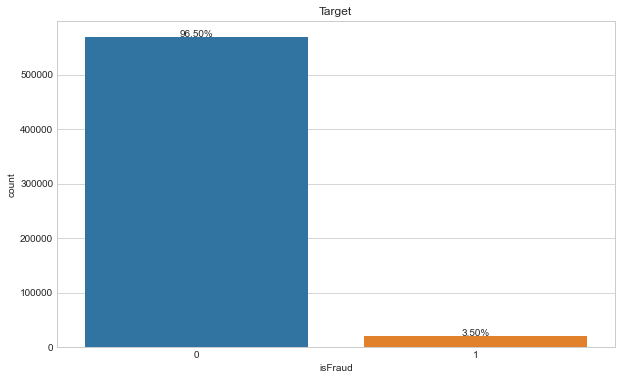

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,6))
sns.countplot(df_train['isFraud'])
axes.title.set_text('Target')
total = float(df_train['isFraud'].shape[0])  
for p in axes.patches:
    height = p.get_height()
    axes.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 
plt.show()

As expected our data is highly imbalanced. About 96.5% of the transactions are not fraud. Only about 3.5% is fraud transactions

## [2.2] TransactionDT


This is actually a timedelta from a given reference datetime (not an actual timestamp). For example: 86400 can be 86400 seconds from a perticulat time, for eg: from 2/12/2010 12:05:09 pm. 

Here we have to check the data obtained in train and test is continous with time. This is important for train-test split. That means training data should be from a earlier period and test data should be from a later period of time.

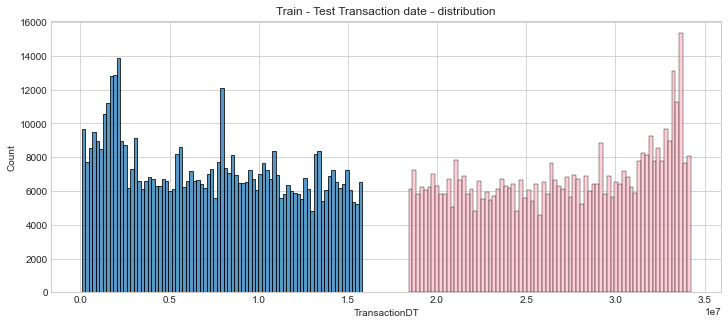

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,5))
sns.histplot(df_train['TransactionDT'])
sns.histplot(df_test['TransactionDT'],color='pink')
axes.title.set_text('Train - Test Transaction date - distribution')
plt.show()

### For visualisation of data on the basis of hourly data - 

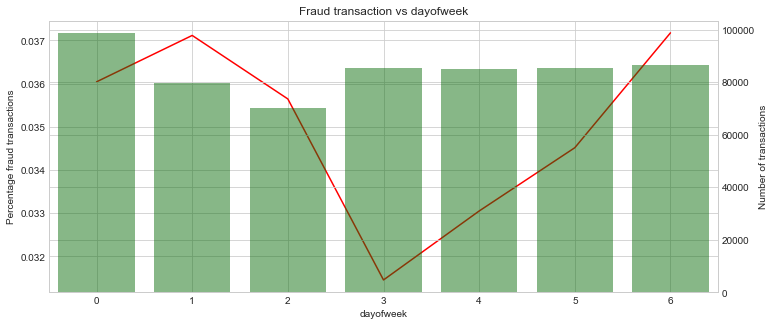

In [22]:
df_train['dayofweek'] = (df_train['TransactionDT']//(60*60*24)-1)%7
tmp = df_train[['isFraud','dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['dayofweek'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['dayofweek'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['dayofweek'],y=tmp['Number of transactions'],color ='green',alpha = .5)
axes.set_title('Fraud transaction vs dayofweek')
plt.show()

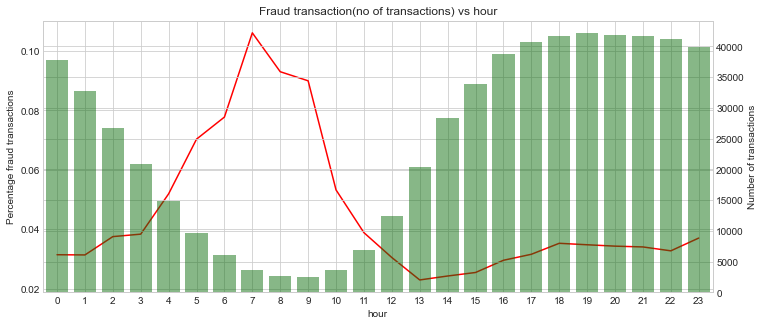

In [23]:
df_train['hour'] = (df_train['TransactionDT']//(60*60))%24
tmp = df_train[['isFraud','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','hour']].groupby(by=['hour']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['hour'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['hour'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['hour'],y=tmp['Number of transactions'],color = 'green',alpha = 0.5)
axes.set_title('Fraud transaction(no of transactions) vs hour')
plt.show()

We can create 4 categorical values from these 

* high(6,7,8,9) : From 6am to 9am
* medium(3,4,5,10,11)
* low(11,12,16-0,1-2)
* very low(13,14,15,)

## [2.3] TransactionAmt

First lets check if any data is missing in this column 

In [24]:
df_train['TransactionAmt'].isnull().sum()

0

Hence, no data is missing 

## Checking for outliers 

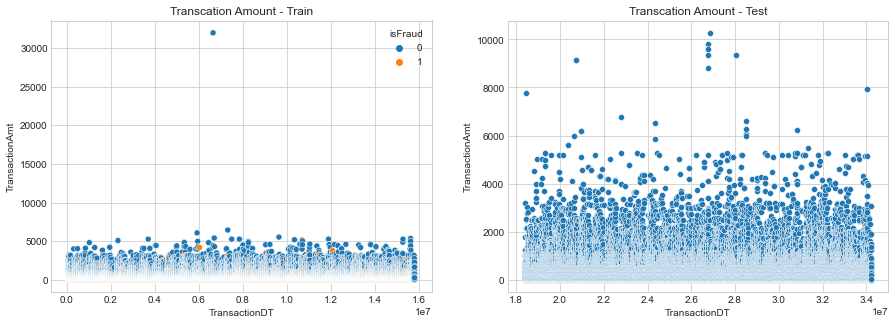

In [25]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(y=df_train['TransactionAmt'],x=df_train['TransactionDT'],hue=df_train['isFraud'],ax=axes[0])
axes[0].title.set_text('Transcation Amount - Train')

sns.scatterplot(y=df_test['TransactionAmt'],x=df_test['TransactionDT'],ax=axes[1])
axes[1].title.set_text('Transcation Amount - Test')

plt.show()

We are detecting for outliers because while training our model it will be better to remove such values for our model to perform better. Especially incase our models are distance based algorithms

### Plotting the probability distribution to see in what ranges the values of fraud and non-fraud detection lie in 

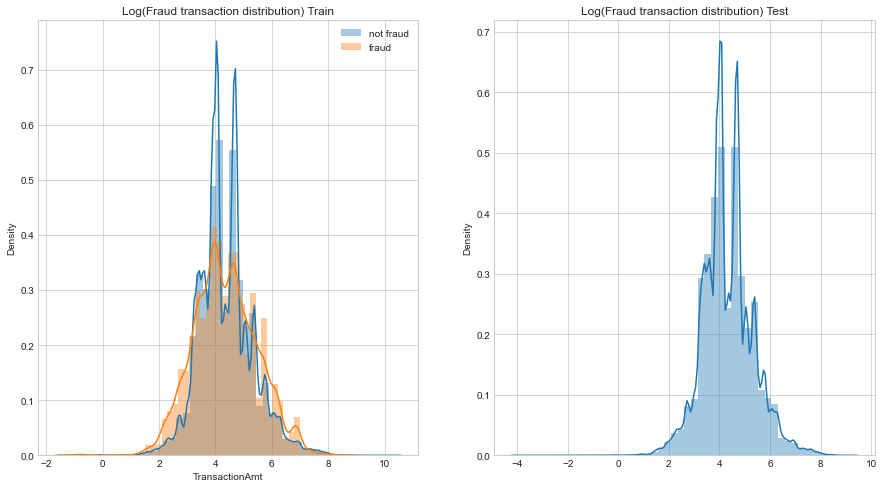

In [26]:
test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = df_train[df_train['isFraud'] == 1]
dff_notfraud = df_train[df_train['isFraud'] == 0]

dff_fraud['TransactionAmt'] = np.log(dff_fraud['TransactionAmt'])
dff_notfraud['TransactionAmt'] = np.log(dff_notfraud['TransactionAmt'])


fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.distplot(dff_notfraud['TransactionAmt'],ax=axes[0],label='not fraud')
sns.distplot(dff_fraud['TransactionAmt'],ax=axes[0],label='fraud')
axes[0].title.set_text('Log(Fraud transaction distribution) Train')
axes[0].legend()

sns.distplot(test_amt,ax=axes[1])
axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()

It seems that the transactions with 'LogTransactionAmt' larger than 5.5 (244 dollars) and smaller than 3.3 (27 dollars) have a higher frequency and probability density of being fraudulent. On the other hand, the ones with 'LogTransactionAmt' from 3.3 to 5.5 have a higher chance of being legit.

## Getting the five number summary for our data for Fraud and Non-Fraud transactions 

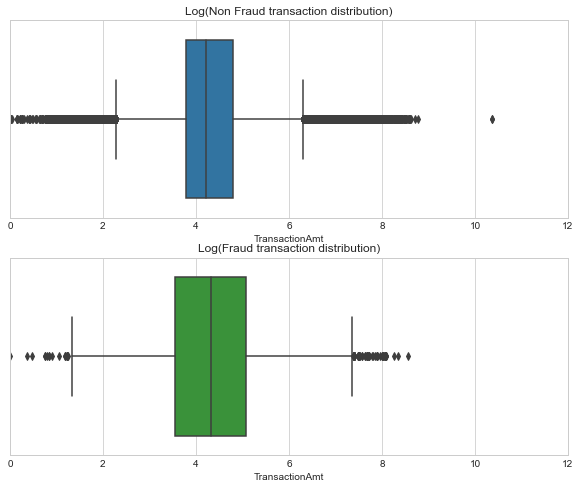

Mean transaction amt for fraud is 4.3506 ie, 77.5264 dollars
Mean transaction amt for non-fraud is 4.3643 ie, 78.5978 dollars
Median transaction amt for fraud is 4.3175  ie, 75.0000 dollars
Median transaction amt for non-fraud is 4.2268  ie, 68.5000 dollars


In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))

## Observations - 

* Fraudulant transactions have slightly higher median.
* Also in Fradulant transactions we have a better normal distribution which is wide at bell curve. It indicates more transactions are present at a particlar intreval which are fraudulant.
* It seems that the transactions with 'LogTransactionAmt' larger than 5.5 (244 dollars) and smaller than 3.3 (27 dollars) have a higher frequency and probability density of being fraudulent. On the other hand, the ones with 'LogTransactionAmt' from 3.3 to 5.5 have a higher chance of being legit.

## P_email domain and R_email domain

Email domain of purchaser and email domain of recipiant

NameError: name 'df_train_transaction' is not defined

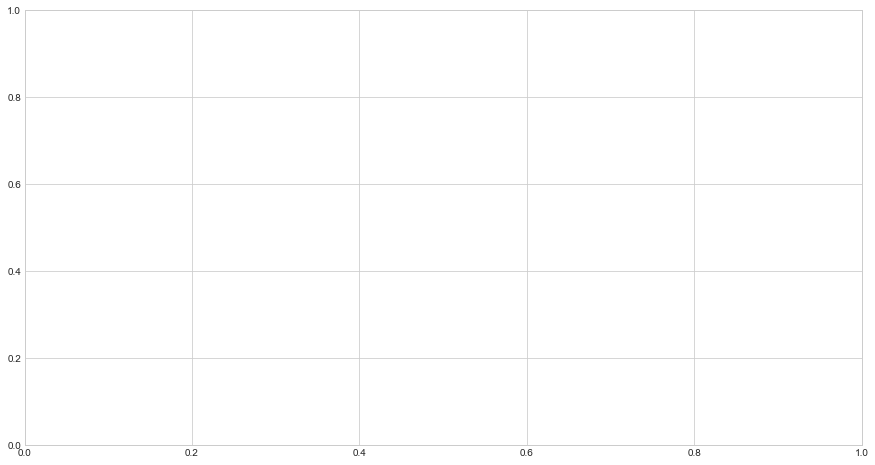

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
sns.countplot(df_train_transaction['P_emaildomain'])
axes.title.set_text('P_emaildomain')
axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

Now let us plot different websites on which fraud is higher, this will help us in understanding which websites are more prone to fraud, infact this will be a great feature to have in our model since this will be able to easily distinguish 

In [29]:
df_train_transaction[['P_emaildomain','isFraud']].groupby(by=['P_emaildomain']).mean() \
        .sort_values(by=['isFraud']).plot(kind='barh',
        figsize=(15, 15),
         title='Percentage of Fraud by Purchaser email domain')
plt.show()

NameError: name 'df_train_transaction' is not defined

### Observations 
* In purchaser email domains most mails are from gmail.com
* Among those More fraud transaction comes from domain protonmail.com which is more than 90% which is a serious issue.

## More Feature Engineering 

### TransactionDT and TransactionID 
Both columns are unique. One is time-related information and the other is a unique id. Adding this to the model doesn't make much sense. So we removed those features.m

### Reducing V Columns 



There are 400 Columns for this feature and the information about this is masked as it is encrypted by the Vesta engineers. Taking all these features would have been very computationally heavy for our model so we decided to drop some of these using covariance analysis. 

### Reducing C cols and M cols
 

In [30]:
# df_train = df_train_transaction.merge(df_train_identity,on=['TransactionID'],how='left')
# df_train.to_csv('data/train_combined.csv',index=False)
# df_train.head()
# gc.collect()

In [31]:
# df_test = df_test_transaction.merge(df_test_identity,on=['TransactionID'],how='left')
# df_test.to_csv('data/test_combined.csv',index=False)
# gc.collect()
# df_test.head()

In [32]:
# # missing_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] > 0.8]
# req_cols = [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0] < 0.7]
# df_train = df_train[req_cols]
# req_cols.remove('isFraud')
# df_test = df_test[req_cols]
# print(df_train.shape)
# print(df_test.shape)

In [33]:
hours = [(hour//(60*60))%24 for hour in df_test.TransactionDT]
days_of_week = [ (hour//(60*60*24)-1)%7 for hour in df_test.TransactionDT]

df_test['hour'] = hours
df_test['dayofweek'] = days_of_week

df_test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,hour,dayofweek
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,2
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,...,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,23,2
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,2
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,2


In [34]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']
X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 433)
(506691, 433)


21292

In [35]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X_train = clean_inf_nan(X_train)
X_test = clean_inf_nan(X_test)

print(X_train.shape)
print(X_test.shape)

(590540, 433)
(506691, 433)


In [36]:

from sklearn.model_selection import train_test_split
X_train_,X_cv_,y_train_,y_cv_ = train_test_split(X_train,y_train, stratify = y_train,test_size=0.3, random_state=40)

print(X_train_.shape)
print(X_cv_.shape)
print(y_train_.shape)
print(y_cv_.shape)


(413378, 433)
(177162, 433)
(413378,)
(177162,)


In [37]:
# X_test['dayofweek'] = (X_test['TransactionDT']//(60*60*24)-1)%7
# tmp = X_test[['isFraud','dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
#             .rename(columns={'isFraud':'Percentage fraud transactions'})

# tmp_count = X_test[['TransactionID','dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
#             .rename(columns={'TransactionID':'Number of transactions'})
# tmp = tmp.merge(tmp_count,on=['dayofweek'])
# tmp

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(exclude=object).columns.tolist()

# 1. Median imputation for numarical features
# 2. Standardizing


# Featurization of numeric data
imputer = SimpleImputer(strategy='median')
x_train_n = imputer.fit_transform(X_train_[num_cols])
x_cv_n = imputer.transform(X_cv_[num_cols])
x_test_n = imputer.transform(X_test[num_cols])

scaler = StandardScaler()
x_train_nums = scaler.fit_transform(x_train_n)
x_cv_nums = scaler.transform(x_cv_n)
x_test_nums = scaler.transform(x_test_n)


x_train_num_final = pd.DataFrame(x_train_nums, columns=num_cols)
x_cv_num_final = pd.DataFrame(x_cv_nums, columns=num_cols)
x_test_num_final = pd.DataFrame(x_test_nums, columns=num_cols)

gc.collect()

print(x_train_num_final.shape)
print(x_cv_num_final.shape)
print(x_test_num_final.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# we are manually giving datatype because some categorical columns are labelled as float/int
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29','addr1','addr2',
'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

for col in cat_cols:
    if col in X_train.columns:
        X_train_[col] = X_train_[col].astype('object')
        X_cv_[col] = X_cv_[col].astype('object')
        X_test[col] = X_test[col].astype('object')
        
        
        X_train_[col]= X_train_[col].fillna('MISSING')
        X_cv_[col]= X_cv_[col].fillna('MISSING')
        X_test[col] = X_test[col].fillna('MISSING')
        
        lb = LabelEncoder()
        lb.fit(list(X_train_[col].values) + list(X_test[col].values) + list(X_cv_[col].values))
        X_train_[col] = lb.transform(list(X_train_[col].values))
        X_cv_[col] = lb.transform(list(X_cv_[col].values)) 
        X_test[col] = lb.transform(list(X_test[col].values))
    

In [145]:
# Final complete data
x_train_num_final = x_train_num_final.reset_index(drop=True)
x_cv_num_final = x_cv_num_final.reset_index(drop=True)
x_test_num_final = x_test_num_final.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_cv = X_cv_.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

x_train = pd.concat([x_train_num_final,X_train_[cat_cols]], axis = 1)
x_cv = pd.concat([x_cv_num_final,X_cv_[cat_cols]], axis = 1)
x_test = pd.concat([x_test_num_final,X_test[cat_cols]], axis = 1)

print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(537388, 451)
(301029, 451)
(506691, 451)


In [147]:
x_train

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,-0.114439,-0.857251,-1.538134,-0.280953,-1.785335,-1.757286,0.069588,-0.217494,-0.086597,-0.074899,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
1,-0.085006,-0.160802,-0.720284,-0.280953,0.644116,1.556155,0.069588,-0.184388,-0.086597,-0.082400,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
2,-0.076386,-1.460623,0.813184,-0.280953,-0.109014,-0.902877,0.069588,-0.184388,-0.086597,-0.082400,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
3,0.104207,1.097379,0.583163,-0.280953,0.644116,0.399577,0.069588,-0.213355,-0.086597,-0.082400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.076386,1.206991,-0.011055,-0.280953,0.644116,1.556155,0.069588,-0.184388,-0.086597,-0.089900,...,162.0,3.0,268.0,4.0,2.0,0.0,2.0,2.0,2.0,1566.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
590536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
590537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0
590538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,6.0,461.0,0.0,1.0,1.0,1.0,1.0,0.0,1159.0


In [146]:
best_est = LogisticRegression(solver='liblinear',class_weight='balanced')
best_est = best_est.fit(x_train,y_train)
y_pred = best_est.predict(x_cv)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').